In [253]:
#!pip install gliner-spacy

In [254]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from gliner_spacy.pipeline import GlinerSpacy

In [255]:
###samp_df.to_csv('samp_df_scales.csv', index=False)

In [256]:
samp_df = pd.read_csv('/content/samp_df_scales.csv')

### Column Info from Scott's Document

a party name that appears in one or more
cases,

some optional “extra info” about the party that may be listed on the docket (I find this
extremely helpful in classification, so much so that I treat it as part of the party name!),

a nature-of-suit subtype2 specifiying the type of case to which this party belongs (which
can also be diagnostic in certain situations),

and a set of case IDs containing parties matching the description given in this row (in
case you want to look at the underlying case files that contain a certain party)

In [257]:
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids
0,Darren Bowens,NaN,crim,['mdd;;1:17-cr-00426']
1,Officer Aaron Collier,CVPD,habeas_corpus,['arwd;;6:16-cv-06006']
2,John Doe No. 2,"Correctional Sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929']
3,Pearlie M Harris,NaN,real_property,['ilnd;;1:04-cv-01953']
4,DANIEL RANDALL,NaN,civil_rights,['paed;;2:13-cv-03864']


In [258]:
samp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 10000 non-null  object
 1   extra_info           2921 non-null   object
 2   nature_suit_subtype  10000 non-null  object
 3   ucids                10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [259]:
samp_df.tail()

,name,extra_info,nature_suit_subtype,ucids
9995,CATHERINE PAPALEO,NaN,contract,"['paed;;2:06-cv-02853', 'paed;;2:06-cv-02853']"
9996,Chief Parrish,NaN,civil_rights,['almd;;1:16-cv-00937']
9997,"BD-2012 Series A, LLC",NaN,contract,['gand;;1:16-cv-01291']
9998,"City of Denham Springs, Louisiana",NaN,contract,"['lamd;;3:16-cv-00015', 'lamd;;3:16-cv-00015']"
9999,ALBA MARTINEZ,COMMISSIONER,civil_rights,"['paed;;2:04-cv-04811', 'paed;;2:03-cv-00905']"


In [260]:
### Take a sample so the process can go easier

#samp_df = df.sample(1000, random_state=1234)

In [261]:
#Missing values in 'extra_info' col but we don't need it anyway
samp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 10000 non-null  object
 1   extra_info           2921 non-null   object
 2   nature_suit_subtype  10000 non-null  object
 3   ucids                10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [262]:
### Just checking for duplicate names in name col -- curiosity

duplicates = samp_df[samp_df.duplicated(subset='name', keep=False)]
duplicates.head()
#duplicates exist John Doe is one but is it Govt or Non?

,name,extra_info,nature_suit_subtype,ucids
14,John Smith,Medical Supervisor,habeas_corpus,"['ctd;;3:17-cv-00325', 'ctd;;3:17-cv-00326']"
24,CREIGHTON E MILLER,ADMINISTRATOR OF THE ESTATE OF OTHER PATRICK G...,personal_injury,['paed;;2:11-cv-47961']
163,John Doe,"Correctional Officer, Montford Unit",habeas_corpus,"['txnd;;5:20-cv-00151', 'txwd;;5:20-cv-00781']"
190,THOMAS JEFFERSON UNIVERSITY,Individually and\ndoing business as\nJEFFERSON...,civil_rights,['paed;;2:21-cv-03731']
191,JANE DOE,c/o Berks County Home,civil_rights,['paed;;5:13-cv-04497']


### Try with NLTK (will use pretrained tokenizers and transformers later)

MAY NOT NEED THIS SECTION

In [263]:
import nltk
from nltk.tokenize import word_tokenize

In [264]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [265]:
def tokenize_column(df, column_name):
    # Define a tokenizer function
    def tokenizer(text):
        if pd.isna(text):
            return []
        tokens = word_tokenize(text)
        # Convert each token to lowercase
        tokens_lower = [token.lower() for token in tokens]
        return tokens_lower
    df[column_name + '_tokenized'] = df[column_name].apply(tokenizer)

    return df

In [266]:
#lowercase/tokenize name using fucntions above
samp_df = tokenize_column(samp_df, 'name')

In [267]:
#sanity check
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized
0,Darren Bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]"
1,Officer Aaron Collier,CVPD,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]"
2,John Doe No. 2,"Correctional Sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]"
3,Pearlie M Harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]"
4,DANIEL RANDALL,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]"


### Goal is classifying non_govt vs govt this is their definition

Part 1: We are interested in the parties (i.e. people or groups involved in litigation) listed on each
docket sheet. Specifically, we hope to develop a method for determining whether a given party
falls into a category we’re calling “government entities.” For our purposes, a government entity is
either a literal governing body (“United States,” “City of Chicago”), a subsidiary or affiliate of
a governing body (“U.S. Department of Education,” “Chicago Police Dept”), or a person
working for one of the above (“Secretary of Education Miguel Cardona,” “Officer Joe Smith”)

**Need some rules to help with this--brainstorming -- all rules should be 'True' if it applies to government entities**


1.   u . s .
2.   Contains 'Department of' or something similar
3. Contains the word 'city of' (saw some examples with **indiv of estate** so added the word 'city' in front of this for narrower scope)
4. DOES NOT Contains 'LLC' (indiv business)
5. Formal Titles ('Secretary, Officer, Judge, d.a.)
6. DOES NOT have Word single letter than word (most likely individuals)?
7. If it has a state name in it or county or city aka GPA (geopolitical entity)
8. If it contains Dept (rule 2 won't capture this)
9. Create a column that adds up the number of toxens in the 'name_tokenized column' -- hypothesis 2 tokens could most likely by an individual
10. If extra_info DOES NOT contain 'indiv'
11. extra_info contains correctional or comissioner or liutenent




### Create new features based on regex pattern (exploration purposes)

In [268]:
samp_df = samp_df.dropna(subset='name')

In [269]:
#make columns lowercase
samp_df['name'] = samp_df['name'].str.lower()
samp_df['extra_info'] = samp_df['extra_info'].str.lower()

In [270]:
#Matches rule 1 above -- shouldn't be case sensitive (add lowercase code above)

regex1 =  r'u\.s\.'
samp_df = samp_df.assign(let_period_let_regex=samp_df['name'].str.contains(regex1))

In [271]:
samp_df['let_period_let_regex'].value_counts()

let_period_let_regex
False    9978
True       22
Name: count, dtype: int64

In [272]:
#Sanity Check -- gave out 'unexpected results' LOOK AT THIS

samp_df[samp_df['let_period_let_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex
979,pentax u.s.a. inc.,NaN,other_statutes,['ilnd;;1:07-cv-06458'],"[pentax, u.s.a., inc, .]",True
1400,u.s. attorney,NaN,civil_rights,"['ohnd;;3:17-cv-00398', 'hid;;1:17-cv-00262', ...","[u.s., attorney]",True
1474,u.s. bank national association,as indentured trustee for sasco mortgage loan ...,real_property,['txsd;;3:17-cv-00215'],"[u.s., bank, national, association]",True
1675,u.s. court of appeals of the third circuit,NaN,civil_rights,['paed;;2:16-cv-06153'],"[u.s., court, of, appeals, of, the, third, cir...",True
1701,u.s. attorney general .,NaN,habeas_corpus,['paed;;2:05-cv-02451'],"[u.s., attorney, general, .]",True
1866,u.s. bankruptcy court district of montana (ip),NaN,bankruptcy,['mtd;;9:17-cv-00009'],"[u.s., bankruptcy, court, district, of, montan...",True
2489,"u.s. bancorp, na",NaN,real_property,['ohsd;;2:17-cv-00105'],"[u.s., bancorp, ,, na]",True
2699,"home depot u.s.a, inc.",a delaware corporation,civil_rights,['cacd;;5:16-cv-00381'],"[home, depot, u.s.a, ,, inc, .]",True
3644,u.s. department of homeland security.,NaN,property_rights,['ilnd;;1:11-cv-00405'],"[u.s., department, of, homeland, security, .]",True
4196,u.s. department of agriculture farmers home ad...,NaN,civil_rights,['kyed;;6:16-cv-00290'],"[u.s., department, of, agriculture, farmers, h...",True


In [273]:
#Matches rule 2 above

regex2 = r'\bdepartment\s+of\b'
samp_df = samp_df.assign(dept_of_regex=samp_df['name'].str.contains(regex2))

In [274]:
samp_df['dept_of_regex'].value_counts()

dept_of_regex
False    9981
True       19
Name: count, dtype: int64

In [275]:
#Sanity Check
samp_df[samp_df['dept_of_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex
232,wyoming department of corrections state penite...,in his official capacity\nalso known as\nethan...,habeas_corpus,['wyd;;2:17-cv-00153'],"[wyoming, department, of, corrections, state, ...",False,True
491,somerville department of public works,NaN,civil_rights,['mad;;1:17-cv-12071'],"[somerville, department, of, public, works]",False,True
654,wyoming department of corrections state penite...,in his/her official capacity\nalso known as\ns...,habeas_corpus,['wyd;;1:16-cv-00244'],"[wyoming, department, of, corrections, state, ...",False,True
990,sacramento department of justice,NaN,civil_rights,['caed;;2:16-cv-03029'],"[sacramento, department, of, justice]",False,True
1644,united states department of air force,NaN,civil_rights,['nmd;;1:17-cv-01272'],"[united, states, department, of, air, force]",False,True
1733,city of chicago department of business affairs...,NaN,civil_rights,['ilnd;;1:22-cv-07317'],"[city, of, chicago, department, of, business, ...",False,True
2678,department of veterans affairs,NaN,other_statutes,"['cacd;;2:16-cv-08675', 'flsd;;9:16-cv-81433',...","[department, of, veterans, affairs]",False,True
3644,u.s. department of homeland security.,NaN,property_rights,['ilnd;;1:11-cv-00405'],"[u.s., department, of, homeland, security, .]",True,True
3877,state of michigan department of human and heal...,NaN,civil_rights,['mied;;2:16-cv-13906'],"[state, of, michigan, department, of, human, a...",False,True
4021,john doe #28 of the nebraska department of cor...,NaN,habeas_corpus,['paed;;2:14-cv-04573'],"[john, doe, #, 28, of, the, nebraska, departme...",False,True


In [276]:
#Matches rule 3 above -- see note about this in markdown above

regex3 = r'\bcity of\b'
samp_df = samp_df.assign(cityof_regex=samp_df['name'].str.contains(regex3))

In [277]:
#Matches rule 13 -- .inc as personal
regex13 = r'\binc\b'
samp_df = samp_df.assign(inc_regex=samp_df['name'].str.contains(regex13))

In [278]:
samp_df[samp_df['inc_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex
20,"ivest 360 syndication group, inc.",NaN,other_statutes,['paed;;2:18-cv-02759'],"[ivest, 360, syndication, group, ,, inc, .]",False,False,False,True
26,dynex capital inc,NaN,real_property,['txnd;;3:17-cv-01147'],"[dynex, capital, inc]",False,False,False,True
34,"brittbrandt, inc.",a california corporation,property_rights,['caed;;1:16-cv-01295'],"[brittbrandt, ,, inc, .]",False,False,False,True
50,sandoz inc.,NaN,other_statutes,"['paed;;2:17-cv-03811', 'paed;;2:13-cv-05097',...","[sandoz, inc, .]",False,False,False,True
57,a.p. green industries inc,a corporation incorporated under the laws of d...,personal_injury,['paed;;2:09-cv-68831'],"[a.p, ., green, industries, inc]",False,False,False,True
...,...,...,...,...,...,...,...,...,...
9954,"tpc group, inc.",NaN,personal_injury,['txsd;;4:18-cv-04678'],"[tpc, group, ,, inc, .]",False,False,False,True
9970,"fedex ground package system, inc.",t/d/b/a fedex ground,civil_rights,['paed;;2:16-cv-01979'],"[fedex, ground, package, system, ,, inc, .]",False,False,False,True
9971,"city carting, inc.",NaN,personal_injury,['ctd;;3:16-cv-01064'],"[city, carting, ,, inc, .]",False,False,False,True
9980,"schumm trucking, inc.",NaN,contract,['ilnd;;1:16-cv-05397'],"[schumm, trucking, ,, inc, .]",False,False,False,True


In [279]:
#Sanity Check
samp_df[samp_df['cityof_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex
189,"montgomery, city of",NaN,civil_rights,"['mied;;5:17-cv-12920', 'nvd;;3:17-cv-00074', ...","[montgomery, ,, city, of]",False,False,True,False
380,city of chicago,as a corporation,civil_rights,['ilnd;;1:06-cv-03433'],"[city, of, chicago]",False,False,True,False
504,city of philadelphia police officer john doe 1,individually and as a police officer for the c...,habeas_corpus,['paed;;2:19-cv-04754'],"[city, of, philadelphia, police, officer, john...",False,False,True,False
514,city of santa monica,a municipal corporation,other_statutes,['cacd;;2:16-cv-04481'],"[city, of, santa, monica]",False,False,True,False
679,"city of new albany, indiana",NaN,civil_rights,['insd;;4:17-cv-00185'],"[city, of, new, albany, ,, indiana]",False,False,True,False
715,"southfield, city of",NaN,civil_rights,['mied;;2:17-cv-10636'],"[southfield, ,, city, of]",False,False,True,False
717,consolidated city of indianapolis / marion cou...,NaN,civil_rights,['insd;;1:17-cv-00036'],"[consolidated, city, of, indianapolis, /, mari...",False,False,True,False
776,the city of upland california,NaN,civil_rights,['cacd;;5:16-cv-02189'],"[the, city, of, upland, california]",False,False,True,False
1053,city of philadelphia health districts,also known as\nfree clinic,civil_rights,['paed;;2:16-cv-01976'],"[city, of, philadelphia, health, districts]",False,False,True,False
1708,city of chicago,"illinois, a municipal corportation",civil_rights,['ilnd;;1:17-cv-04839'],"[city, of, chicago]",False,False,True,False


In [280]:
#Matches rule 4 above
regex4 = r'^(?!.*l\.l\.c\.).*$'
samp_df = samp_df.assign(llc_regex=samp_df['name'].str.contains(regex4))

In [281]:
#Matches rule 12 -- llc
regex12 = r'^(?!.*llc).*$'
samp_df = samp_df.assign(word_llc_regex=samp_df['name'].str.contains(regex12))


In [282]:
samp_df[samp_df['word_llc_regex'] == False]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex
64,al kawthar international llc,NaN,labor,['vaed;;1:16-cv-00652'],"[al, kawthar, international, llc]",False,False,False,False,True,False
98,"dreamdealers usa, llc",doing business as\nexotics racing\ndoing busin...,property_rights,['nvd;;2:17-cv-02697'],"[dreamdealers, usa, ,, llc]",False,False,False,False,True,False
114,advanced reimbursement management holdings llc,doing business as\nadreima,contract,['flnd;;4:16-cv-00191'],"[advanced, reimbursement, management, holdings...",False,False,False,False,True,False
142,d & l rocks llc,NaN,other_statutes,['laed;;2:16-cv-06037'],"[d, &, l, rocks, llc]",False,False,False,False,True,False
228,housekeeping services of hilton head llc,NaN,labor,['scd;;9:17-cv-00800'],"[housekeeping, services, of, hilton, head, llc]",False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
9926,"classicstar, llc",NaN,contract,"['paed;;2:07-cv-04885', 'paed;;2:08-cv-00246']","[classicstar, ,, llc]",False,False,False,False,True,False
9930,"north shore compassionate care, llc",NaN,labor,['ilnd;;1:20-cv-07034'],"[north, shore, compassionate, care, ,, llc]",False,False,False,False,True,False
9964,healthcare investor partners llc,NaN,crim,['txnd;;3:18-cr-00475'],"[healthcare, investor, partners, llc]",False,False,False,False,True,False
9966,northwest allied physicians llc,NaN,personal_injury,['azd;;4:16-cv-00279'],"[northwest, allied, physicians, llc]",False,False,False,False,True,False


In [283]:
#Sanity Check
samp_df[samp_df['llc_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",False,False,False,False,True,True
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",False,False,False,False,True,True
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",False,False,False,False,True,True
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
9995,catherine papaleo,NaN,contract,"['paed;;2:06-cv-02853', 'paed;;2:06-cv-02853']","[catherine, papaleo]",False,False,False,False,True,True
9996,chief parrish,NaN,civil_rights,['almd;;1:16-cv-00937'],"[chief, parrish]",False,False,False,False,True,True
9997,"bd-2012 series a, llc",NaN,contract,['gand;;1:16-cv-01291'],"[bd-2012, series, a, ,, llc]",False,False,False,False,True,False
9998,"city of denham springs, louisiana",NaN,contract,"['lamd;;3:16-cv-00015', 'lamd;;3:16-cv-00015']","[city, of, denham, springs, ,, louisiana]",False,False,True,False,True,True


In [284]:
#Matches rule 5 above -- need to think of more formal titles here
regex5 = r'(?:secretary|officer|judge|district attorney|police|detective|warden|fbi|commissioner|chief|district attorney\'s)\s+\w+'
samp_df = samp_df.assign(formal_regex=samp_df['name'].str.contains(regex5))

In [285]:
#Sanity Check
samp_df[samp_df['formal_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True
61,officer robert otto,NaN,civil_rights,['paed;;2:17-cv-05189'],"[officer, robert, otto]",False,False,False,False,True,True,True
63,police officer david killingsworth,NaN,civil_rights,['paed;;2:13-cv-00256'],"[police, officer, david, killingsworth]",False,False,False,False,True,True,True
152,e chicago police detective,NaN,civil_rights,['ilnd;;1:02-cv-07553'],"[e, chicago, police, detective]",False,False,False,False,True,True,True
379,asst. warden fnu markum,NaN,habeas_corpus,['txwd;;6:16-cv-00467'],"[asst, ., warden, fnu, markum]",False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9827,cameron county district attorney's office,NaN,habeas_corpus,['txsd;;1:16-cv-00007'],"[cameron, county, district, attorney, 's, office]",False,False,False,False,True,True,True
9873,chief james barber,NaN,civil_rights,['alsd;;1:16-cv-00025'],"[chief, james, barber]",False,False,False,False,True,True,True
9923,forest park police dept.,NaN,civil_rights,"['ilnd;;1:02-cv-07472', 'ilnd;;1:16-cv-08227']","[forest, park, police, dept, .]",False,False,False,False,True,True,True
9938,police officer daniel healey,NaN,civil_rights,['nyed;;1:16-cv-02484'],"[police, officer, daniel, healey]",False,False,False,False,True,True,True


In [286]:
#Matches rule 6 above

regex6 = r'^(?!\b\w+\s+[a-zA-Z]\s+\w+\b).*$'

samp_df = samp_df.assign(word_let_word_regex=samp_df['name'].str.contains(regex6))


In [287]:
samp_df[samp_df['word_let_word_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",False,False,False,False,True,True,False,True
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True,True
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",False,False,False,False,True,True,False,True
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",False,False,False,False,True,True,False,True
5,jennie jones-hurdlow,NaN,contract,"['azd;;4:17-cv-00288', 'azd;;4:17-cv-00288', '...","[jennie, jones-hurdlow]",False,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,catherine papaleo,NaN,contract,"['paed;;2:06-cv-02853', 'paed;;2:06-cv-02853']","[catherine, papaleo]",False,False,False,False,True,True,False,True
9996,chief parrish,NaN,civil_rights,['almd;;1:16-cv-00937'],"[chief, parrish]",False,False,False,False,True,True,True,True
9997,"bd-2012 series a, llc",NaN,contract,['gand;;1:16-cv-01291'],"[bd-2012, series, a, ,, llc]",False,False,False,False,True,False,False,True
9998,"city of denham springs, louisiana",NaN,contract,"['lamd;;3:16-cv-00015', 'lamd;;3:16-cv-00015']","[city, of, denham, springs, ,, louisiana]",False,False,True,False,True,True,False,True


In [288]:
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",False,False,False,False,True,True,False,True
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True,True
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",False,False,False,False,True,True,False,True
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",False,False,False,False,True,True,False,False
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",False,False,False,False,True,True,False,True


In [289]:
#Matches rule 7 above -- may not need rule 1 or 3 above if this rule is used hypothesis for now
# nlp = spacy.load("en_core_web_sm")

# # Function to identify state names in a text
# def identify_state(text):
#     # Process the text with spaCy
#     doc = nlp(text)

#     # Extract state names
#     state_names = []
#     for ent in doc.ents:
#         if ent.label_ == "GPE":  # GPE: geopolitical entity (e.g., countries, cities, states)
#             state_names.append(ent.text.lower())

#     # Check if any of the extracted entities are state names
#     for state in state_names:
#         if state in state_names:
#             return True

#     return False

In [290]:
#samp_df['state_mentioned_regex'] = samp_df['name'].apply(identify_state)

In [291]:
#samp_df[samp_df['state_mentioned_regex'] == True]

In [292]:
#Matches rule #8 -- dept
regex8 = r'\bdept\b'

samp_df = samp_df.assign(dept_regex=samp_df['name'].str.contains(regex8))

In [293]:
samp_df[samp_df['dept_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex,dept_regex
206,la dept of transportation & development,NaN,personal_injury,"['lawd;;6:16-cv-01248', 'lawd;;2:16-cv-01524',...","[la, dept, of, transportation, &, development]",False,False,False,False,True,True,False,True,True
425,mailroom-r+d dept.,NaN,habeas_corpus,['ilnd;;3:20-cv-50059'],"[mailroom-r+d, dept, .]",False,False,False,False,True,True,False,True,True
781,cook county dept. of facilities management,NaN,civil_rights,['ilnd;;1:13-cv-02387'],"[cook, county, dept, ., of, facilities, manage...",False,False,False,False,True,True,False,True,True
1686,ingham county sheriff dept.,NaN,habeas_corpus,['mied;;2:17-cv-10777'],"[ingham, county, sheriff, dept, .]",False,False,False,False,True,True,False,True,True
3551,rockford police dept.,a local governmental agency,habeas_corpus,['ilnd;;3:08-cv-50272'],"[rockford, police, dept, .]",False,False,False,False,True,True,True,True,True
4892,whiteside county sheriffs dept.,NaN,habeas_corpus,['ilnd;;3:12-cv-50216'],"[whiteside, county, sheriffs, dept, .]",False,False,False,False,True,True,False,True,True
6111,west manchester police dept.,NaN,habeas_corpus,['paed;;2:10-cv-04748'],"[west, manchester, police, dept, .]",False,False,False,False,True,True,True,True,True
6291,state of alaska dept. of correction,NaN,habeas_corpus,['akd;;3:17-cv-00199'],"[state, of, alaska, dept, ., of, correction]",False,False,False,False,True,True,False,True,True
6366,lower merion police dept.,NaN,civil_rights,['paed;;2:12-cv-02419'],"[lower, merion, police, dept, .]",False,False,False,False,True,True,True,True,True
6909,chicago police dept.,et.al.,habeas_corpus,['ilnd;;1:06-cv-04184'],"[chicago, police, dept, .]",False,False,False,False,True,True,True,True,True


In [294]:
#Matches rule #9 -- tokens

samp_df['token_count_eq2'] = samp_df['name_tokenized'].apply(lambda x: len(x))


In [295]:
#Sanity Check
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex,dept_regex,token_count_eq2
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",False,False,False,False,True,True,False,True,False,2
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True,True,False,3
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",False,False,False,False,True,True,False,True,False,5
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",False,False,False,False,True,True,False,False,False,3
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",False,False,False,False,True,True,False,True,False,2


In [296]:
#Make a cloumn that is True if you have two tokens -- highest being an individual

samp_df['two_tokens'] = (samp_df['token_count_eq2'] == 2).astype(int)
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex,dept_regex,token_count_eq2,two_tokens
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",False,False,False,False,True,True,False,True,False,2,1
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True,True,False,3,0
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",False,False,False,False,True,True,False,True,False,5,0
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",False,False,False,False,True,True,False,False,False,3,0
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",False,False,False,False,True,True,False,True,False,2,1


In [297]:
#Make a cloumn that is True if you have three tokens

samp_df['three_tokens'] = (samp_df['token_count_eq2'] == 3).astype(int)
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex,dept_regex,token_count_eq2,two_tokens,three_tokens
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",False,False,False,False,True,True,False,True,False,2,1,0
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True,True,False,3,0,1
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",False,False,False,False,True,True,False,True,False,5,0,0
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",False,False,False,False,True,True,False,False,False,3,0,1
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",False,False,False,False,True,True,False,True,False,2,1,0


In [298]:
#Matches rule 10 -- extra_info contain 'indiv'
regex10 = r'^(?!.*\bindividual|individually\b).*$'

samp_df = samp_df.assign(extra_info_notindiv_regex=samp_df['extra_info'].str.contains(regex10))

In [299]:
samp_df[samp_df['extra_info_notindiv_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex,dept_regex,token_count_eq2,two_tokens,three_tokens,extra_info_notindiv_regex
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True,True,False,3,0,1,True
11,real property located at 2255 elkhorn boulevar...,apn: 207-0202-046-0000,forfeiture/penalty,['caed;;2:16-cv-02394'],"[real, property, located, at, 2255, elkhorn, b...",False,False,False,False,True,True,False,True,False,12,0,0,True
14,john smith,medical supervisor,habeas_corpus,"['ctd;;3:17-cv-00325', 'ctd;;3:17-cv-00326']","[john, smith]",False,False,False,False,True,True,False,True,False,2,1,0,True
18,office team,a robert half company,civil_rights,['gand;;1:17-cv-04659'],"[office, team]",False,False,False,False,True,True,False,True,False,2,1,0,True
24,creighton e miller,administrator of the estate of other patrick g...,personal_injury,['paed;;2:11-cv-47961'],"[creighton, e, miller]",False,False,False,False,True,True,False,False,False,3,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,afscme members,added per first amended complaint 11/9/16,habeas_corpus,['ilsd;;3:16-cv-00978'],"[afscme, members]",False,False,False,False,True,True,False,True,False,2,1,0,True
9970,"fedex ground package system, inc.",t/d/b/a fedex ground,civil_rights,['paed;;2:16-cv-01979'],"[fedex, ground, package, system, ,, inc, .]",False,False,False,True,True,True,False,True,False,7,0,0,True
9974,john doe,(first and last names being fictitious),personal_injury,['paed;;2:08-cv-05670'],"[john, doe]",False,False,False,False,True,True,False,True,False,2,1,0,True
9993,mr. toole,ga attack squad / former warden in state of ge...,habeas_corpus,['gasd;;5:17-cv-00133'],"[mr., toole]",False,False,False,False,True,True,False,True,False,2,1,0,True


In [300]:
#Matches rule 11
regex11 = r'(?:commissioner|officer|lieutenant|district attorney|^commissioner)\s+\w+'
samp_df = samp_df.assign(extra_info_formal=samp_df['extra_info'].str.contains(regex11))

In [301]:
samp_df[samp_df['extra_info_formal'] == True].shape

(38, 19)

In [302]:
samp_df['extra_info_formal'].isna().sum()

7079

In [303]:
samp_df['nature_suit_subtype'].value_counts()

nature_suit_subtype
personal_injury       2172
civil_rights          1571
habeas_corpus         1322
other_statutes         862
property_rights        827
labor                  774
contract               763
crim                   726
real_property          293
personal_property      201
social_security        162
prisoner_petitions     115
bankruptcy              72
immigration             72
forfeiture/penalty      32
federal_tax_suits       26
civil_detainee          10
Name: count, dtype: int64

In [304]:
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex,dept_regex,token_count_eq2,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",False,False,False,False,True,True,False,True,False,2,1,0,NaN,NaN
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",False,False,False,False,True,True,True,True,False,3,0,1,True,False
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",False,False,False,False,True,True,False,True,False,5,0,0,False,False
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",False,False,False,False,True,True,False,False,False,3,0,1,NaN,NaN
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",False,False,False,False,True,True,False,True,False,2,1,0,NaN,NaN


### Creating target from regexs above

In [305]:
#samp_df['Target'] = ''
#samp_df.loc[samp_df['formal_regex'], 'Target'] = 'government'
#samp_df.loc[(samp_df['state_mentioned_regex'] & samp_df['dept_regex']), 'Target'] = 'government'
#samp_df.loc[(samp_df['state_mentioned_regex'] & samp_df['dept_of_regex']), 'Target'] = 'government'
#samp_df.loc[(samp_df['extra_info_notindiv_regex'] == False) & (samp_df['two_tokens']), 'Target'] = 'person'
#samp_df.loc[(samp_df['nature_suit_subtype'] == 'crim') & (samp_df['word_let_word_regex']), 'Target'] = 'person'
#samp_df.loc[(samp_df['let_period_let_regex'] == False) & ((samp_df['token_count_eq2']==2) | (samp_df['token_count_eq2'] ==3)), 'Target'] = 'person'


KeyError: 'state_mentioned_regex'

In [306]:
#Checking for overlap for if below
samp_df.loc[(samp_df['word_let_word_regex'] == False) & (samp_df['let_period_let_regex'])]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,let_period_let_regex,dept_of_regex,cityof_regex,inc_regex,llc_regex,word_llc_regex,formal_regex,word_let_word_regex,dept_regex,token_count_eq2,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal,Target


In [307]:
def apply_conditions(row):
    if row['formal_regex']:
        return 'government'
    elif row['dept_regex']:
        return 'government'
    elif row['dept_of_regex']:
        return 'government'
    elif row['cityof_regex']:
        return 'government'
    elif row['extra_info_formal'] == True:
        return 'government'
    elif row['let_period_let_regex']:
        return 'government'
    elif row['nature_suit_subtype'] == 'immigration':
        return 'government'
    elif row['extra_info_notindiv_regex'] == False:
        return 'person'
    elif row['llc_regex'] == False:
        return 'person'
    elif row['word_let_word_regex'] == False:
        return 'person'
    elif row['word_llc_regex'] == False:
        return 'person'
    elif row['two_tokens'] == 1:
        return 'person'
    elif row['three_tokens'] == 1:
        return 'person'
    elif row['nature_suit_subtype'] == 'crim':
        return 'person'
    elif row['inc_regex']:
        return 'person'
    else:
        return 'no_condition_met'

In [ ]:
samp_df.head()

In [308]:
samp_df['target_v1'] = samp_df.apply(apply_conditions, axis=1)

In [309]:
samp_df['target_v1'].value_counts()

target_v1
person              8191
no_condition_met    1467
government           342
Name: count, dtype: int64

In [ ]:
samp_df.loc[samp_df['target_v1'] == 'no_condition_met'].tail(50)

In [318]:
# Set 'person' to 0 and 'government' to 1
samp_df['target_v2'] = samp_df['target_v1'].replace({'person': 0, 'government': 1, 'no_condition_met': 0})

In [319]:
samp_df['target_v2'].value_counts()

target_v2
0    9658
1     342
Name: count, dtype: int64

In [ ]:
samp_df.head()

### Modeling on rule-based target

In [311]:
#Replace true/false with 1/0 across dataframe

samp_df = samp_df.replace({False: 0, True: 1})


In [ ]:
samp_df.head()

In [329]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score

In [ ]:
samp_df.info()

In [342]:
X = samp_df.drop(['target_v1', 'name', 'ucids', 'name_tokenized', 'Target', 'extra_info',
                  'target_v1', 'nature_suit_subtype', 'extra_info_notindiv_regex', 'extra_info_formal',
                  'three_tokens', 'two_tokens', 'target_v2'], axis=1)
y = samp_df['target_v2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5242)

In [ ]:
X_train.head()

In [ ]:
y_test

In [345]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
dt.score(X_train, y_train)
#dt.predict(X_test)


0.986

In [348]:
dt.feature_names_in_
dt.feature_importances_


array([0.        , 0.        , 0.14928146, 0.        , 0.        ,
       0.        , 0.85071854, 0.        , 0.        , 0.        ])

[Text(0.6, 0.8333333333333334, 'x[6] <= 0.5\ngini = 0.064\nsamples = 7500\nvalue = [7252, 248]'),
 Text(0.4, 0.5, 'x[2] <= 0.5\ngini = 0.034\nsamples = 7378\nvalue = [7252, 126]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.028\nsamples = 7357\nvalue = [7252, 105]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 122\nvalue = [0, 122]')]

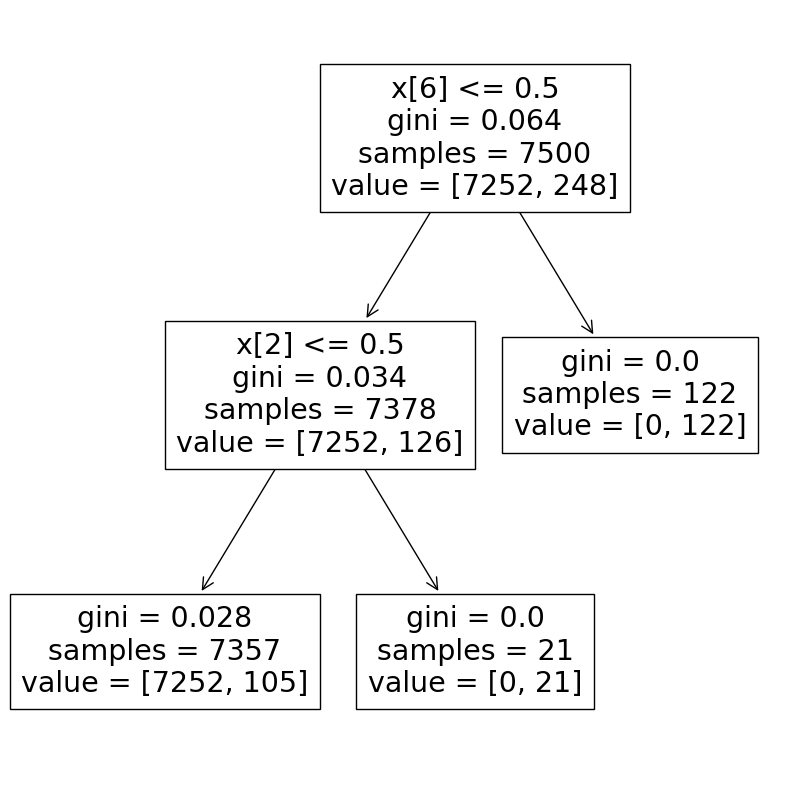

In [349]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(dt, ax=ax)

Is a particular subtype related to one of the regex rules??? Have some assumptions here.

**also can we do a hand label on a small small sample and see if any of these regexs become predictive**

### Foundational NER Model ZeroShot just using 'person' and 'government' as the entities

In [ ]:
#Thinking about doing this zero-shot NER with custom label model
#!pip install gliner-spacy

In [ ]:
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from gliner_spacy.pipeline import GlinerSpacy

In [ ]:
## loaded the spacy model in the function above as 'nlp'

nlp.add_pipe("gliner_spacy", config={"labels": ['person', 'government' ]})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/792M [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [ ]:
samp_df['name'] = samp_df['name'].astype(str)

# Create an empty list to store the labels
labels_list = []

# Iterate over the 'text_column' using spaCy
for text in samp_df['name']:
    doc = nlp(text)
    # Process the text as needed
    # For example, store entities in each document
    labels = [ent.label_ for ent in doc.ents]
    #print(text,labels)
    labels_list.append(labels)

# Add the labels as a new column to the DataFrame
samp_df['zero_shot_labelsv1'] = labels_list

KeyboardInterrupt: 

In [ ]:
### samp_df.to_csv('samp_df_zeroshot.csv', index=False)